<a href="https://colab.research.google.com/github/abogdanova/DC-SHAP/blob/main/DC_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import collections
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.random_projection import SparseRandomProjection
from sklearn.manifold import LocallyLinearEmbedding, MDS
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.datasets import load_breast_cancer, load_wine, load_iris
from scipy import linalg
import matplotlib.pyplot as plt
import scipy

import itertools
import shap

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DC Utilities

In [ ]:
'''
This block contains functionality of Data Collaboraiton including different methods to produce anchor data
'''

def make_anchors(X, nanc, categorical_index=[]):
    """
    X_lst := raw training data list
    nanc := the number of anchor_data
    categorical_index := index-list of categorical value
    """
    # X = np.concatenate((X_lst[0], X_lst[1]),axis=0)
    anc_data = np.zeros((nanc, X.shape[1]))
    random_state = check_random_state(None)
    for ind in range(X.shape[1]):  # make anchor data for numeric-value
        if ind in categorical_index:
            continue
        # numeric_feat_min = np.min(X[:, ind])
        # numeric_feat_max = np.max(X[:, ind])
        # anc_data[:, ind] = np.random.uniform(numeric_feat_min, numeric_feat_max, (nanc))
        numeric_feat_mean = np.mean(X[:, ind])
        numeric_feat_sigma = np.std(X[:, ind])
        anc_data[:, ind] = np.random.normal(numeric_feat_mean, numeric_feat_sigma, nanc)

    for ind in categorical_index:  # make anchor data for categorical-value
        feat_count = collections.Counter(X[:, ind])
        values, frequencies = map(list, zip(*(sorted(feat_count.items()))))
        freqs = (np.array(frequencies) / float(sum(frequencies)))
        anc_column = random_state.choice(values, size=nanc, replace=True, p=freqs)
        anc_data[:, ind] = anc_column

    return anc_data

def make_anchors_rand_svd(X, nanc, d):
  """
  X := raw training data
  nanc := the number of anchor_data
  d := dimension for SVD transformation 
  """

  svd = TruncatedSVD(d).fit(X)
  x_svd = svd.transform(X)
  rand_anc = make_anchors(x_svd, nanc)

  return svd.inverse_transform(rand_anc)

def make_anchors_svd(Xtrain, nanc, delta = 0.01, epsilon=1):
  m = Xtrain.shape[1]
  n = Xtrain.shape[0]
  mn = np.min(Xtrain)
  mx = np.max(Xtrain)

  # low rank approximation
  U, S, V = np.linalg.svd(Xtrain, full_matrices=False)
  k = np.sum(S/S[0] >= delta)
  U1 = U[:,:k]
  S1 = np.diag(S)[:k, :k]
  V1 = V[:k, :]
  anc = np.dot(U1, np.dot(S1, V1))

  # add noise
  X_noise = np.zeros(anc.shape)
  for i in range(len(anc)):
    X_noise[i] = np.random.laplace(0, 1/epsilon, anc.shape[1:])            
  anc += X_noise
  
  # linear combination
  grow = int(nanc/n)
  if grow > 0:
    D = np.kron(np.ones((1,grow)), np.eye(n)) + 0.001*np.random.randn(n, n*grow)
    D = D / np.sum(D,0)
    anc = np.dot(anc.T, D).T
  else:
    anc = anc[:nanc]

  return anc


class DataColab(object):
    def __init__(self, Xanc_lst, p, d, method='SVD', affine=True):
        """
        input:
          Xanc_lst := list of anchor data.
                        Xanc_lst[i] := anchor data in party i.
          p := the num of dimentions in embedding representation.
          d := the num of dimentions in DC representation.
        """
        self.nparty = len(Xanc_lst)

        # for Xanc in Xanc_lst:
        self.Xanc_lst = Xanc_lst
        self.p = p
        self.d = d
        self.method = method
        self.F_lst = []
        self.G_lst = []
        self.affine = affine

    def get_dc_train(self, Y_lst, G_lst):
        """
        input;
          Y_lst := embedding representation list of training data.
                    Yanc_lst[i] := embedding-representation of training data in party i.
          G_lst : mapping matrix from embedding to DC-representation-data list.
                    G_lst[i] := mapping matrix in party i.
        output;
          Y_hat_lst := DC-representation-data of training data;
        """
        if len(Y_lst) != len(G_lst):
            raise ValueError('''size of Y_lst and G_lst must be same''')

        data_type = Y_lst[0].dtype  # data type
        Y_hat_lst = np.empty((0, G_lst[0].T.shape[1]), data_type)

        for Y_i, G_i in zip(Y_lst, G_lst):
            if self.affine:
                Y_i = np.c_[Y_i, np.ones(Y_i.shape[0])]
            Y_hat_i = np.dot(Y_i, G_i.T)
            Y_hat_lst = np.concatenate((Y_hat_lst, Y_hat_i), axis=0)

        return Y_hat_lst

    def convert_dc_rep(self, Xtest, user_id):
        """
        input;
          Xtest := raw test data.
          user_id := set user-id bounded by raw test data.
        output;
          Y_hat_i := DC-representation-data of raw test data;
        """
        method = self.method
        G_i = self.G_lst[user_id]
        F_i = self.F_lst[user_id]

        if method == 'SVD':
            Y_i = np.dot(Xtest, F_i.T)
        else:
            Y_i = F_i.transform(Xtest)

        if self.affine:
            Y_i = np.c_[Y_i, np.ones(Y_i.shape[0])]

        Y_hat_i = np.dot(Y_i, G_i.T)
        return Y_hat_i

    def convert_dc_rep_inv(self, Z, user_id):
        G_inv = np.linalg.pinv(self.G_lst[user_id])
        F_inv = np.linalg.pinv(self.F_lst[user_id])
        Y = np.dot(Z, G_inv.T)
        X = np.dot(Y, F_inv.T)
        return X

    def convert_embedding(self, X, user_id):
        """
        input;
          X := raw data.
          user_id := set user-id bounded by raw test data.
        output;
          Y_i := embedding-representation-data of raw test data;
        """
        method = self.method
        F_i = self.F_lst[user_id]

        if method == 'SVD':
            Y_i = np.dot(X, F_i.T)
        else:
            Y_i = F_i.transform(X)

        return Y_i

    def get_embedding(self, X, Xanc, p, method='SVD'):
        """
        input;
          X := raw train data
          Xanc := raw anchor data
          p := num of embedding dimention
          method := dimention reduction method

        output;
          Y := embedding-representation of training-data
          Y_anc := embedding-representaion of anchor-data
        """
        if method == 'PCA':
            F = PCA(p, svd_solver='full')

        elif method == 'ICA':
            F = FastICA(p)

        elif method == 'SRP':
            F = SparseRandomProjection(p)

        elif method == 'LLE':
            F = LocallyLinearEmbedding(n_neighbors=15, n_components=p)

        else:
            U1, S1, V1 = linalg.svd(X, lapack_driver='gesvd')
            # U1, S1, V1 = np.linalg.svd(X, full_matrices=False)
            F = V1[:p, :]
            Y = np.dot(X, F.T)
            if Xanc.shape[1] != p:
                Yanc = np.dot(Xanc, F.T)
            else:
                Yanc = Xanc
            self.F_lst.append(F)

            return Y, Yanc

        Y = F.fit_transform(X)
        if Xanc.shape[1] != p:
            Yanc = F.fit_transform(Xanc)
        else:
            Yanc = Xanc
        self.F_lst.append(F)

        return Y, Yanc

    def make_dc_map(self, Yanc_lst, d):  # get transformation functions
        """
        input;
          Yanc_lst := embedding representation of anchor data list.
                    Yanc_lst[i] := embedding representation of anchor data in party i.
          d := the number of dimention in DC representation.

        output;
          G_lst := list of transformation function.
                 G_lst[i] := transformation function for party i.
        """
        nanc = Yanc_lst[0].shape[0]  # num of anchor data
        data_type = Yanc_lst[0].dtype  # anchor data type

        anc_merged = np.empty((nanc, 0), data_type)
        for Yanc_i in Yanc_lst:
            anc_merged = np.concatenate((anc_merged, Yanc_i), axis=1)

        U, S, V = linalg.svd(anc_merged, lapack_driver='gesvd')
        # U, S, V = np.linalg.svd(anc_merged, full_matrices=False)

        Z = U.T[:d, :]

        # affine transformations

        G_lst = []
        for e in Yanc_lst:
            if self.affine:
                e = np.c_[e, np.ones(e.shape[0])]
            G_lst.append(np.dot(Z, np.linalg.pinv(e.T)))

        return Z, G_lst  # transformation function list

    def data_collaboration(self, X_lst):
        """
        input:
          X_lst := list of raw train data.
            X_lst[i] := raw train data in party i.
        output:
          DC representation of raw train data.
        """

        Xanc_lst = self.Xanc_lst

        data_type = Xanc_lst[0].dtype  # data type

        #     Xanc_merged = np.empty((0, Xanc_lst[0].shape[1]), data_type)
        #     for Xanc in Xanc_lst:
        #       Xanc_merged = np.concatenate((Xanc_merged, Xanc), axis=0)

        p = self.p
        d = self.d
        nparty = self.nparty
        method = self.method
        # creating intermediate representations
        Y_lst = []
        Yanc_lst = []
        for i in range(nparty):
            Y, Yanc = self.get_embedding(X_lst[i], Xanc_lst[i], p, method=method)
            Y_lst.append(Y)
            Yanc_lst.append(Yanc)

        Z, G_lst = self.make_dc_map(Yanc_lst, d)  ###
        self.Z = Z
        self.G_lst = G_lst

        return self.get_dc_train(Y_lst, G_lst)

#Data Prep

## Adult

Each cell below overwtites the X data variable. Pick just one dataset at a time.
Adult dataset should be downloaded from http://archive.ics.uci.edu/dataset/2/adult and placed into appropriate drive folder. Heart dataset is taken from https://archive.ics.uci.edu/dataset/45/heart+disease 


In [ ]:
data = pd.read_csv('drive/MyDrive/Data/adult.csv')

data.dropna(inplace=True)

#encode target variable
le = LabelEncoder()
y = le.fit_transform(data['income'])
target_names = ['<50K', '50K<']

# drop to match Wang's paper
data.drop(columns=['fnlwgt', 'education','income'], inplace=True)

# label encode categorical data
obj_df = data.select_dtypes(include=['object']).copy()
num_df = data.select_dtypes(include=['int64']).copy()

for column in obj_df.columns:
  le = LabelEncoder()
  obj_df[column] = le.fit_transform(obj_df[column])

# make X
X = np.concatenate((np.array(num_df), np.array(obj_df)), axis=1)

# reshaffle columns to match Wang paper
original_features = num_df.columns.values.tolist() + obj_df.columns.values.tolist()


feature_names = ['Age', 'Country', 'Education-Num', 'Marital Status', 'Relationship',  'Race', 'Sex', 
                 'Capital Gain', 'Capital Loss',  
                 'Workclass', 'Occupation', 'Hours per week']

feature_names = original_features

print("Data shape: ", X.shape)
print("Feature names: ", feature_names)
print("Target names: ", target_names)

# check dataframe
pd.DataFrame(X, columns=feature_names).head()

Data shape:  (32561, 12)
Feature names:  ['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week', 'workclass', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
Target names:  ['<50K', '50K<']


,age,education.num,capital.gain,capital.loss,hours.per.week,workclass,marital.status,occupation,relationship,race,sex,native.country
0,90,9,0,4356,40,0,6,0,1,4,0,39
1,82,9,0,4356,18,4,6,4,1,4,0,39
2,66,10,0,4356,40,0,6,0,4,2,0,39
3,54,4,0,3900,40,4,0,7,4,4,0,39
4,41,10,0,3900,40,4,5,10,3,4,0,39


## Heart

In [ ]:
data = pd.read_csv('drive/MyDrive/Data/heart.csv')

X = data.drop(columns='target')
y = data['target']

feature_names = np.array(X.columns)

print(feature_names)
cat_features = [1,2,5,6,8,10,11,12]
data.head()

['age' 'sex' 'cp' 'trestbps' 'chol' 'fbs' 'restecg' 'thalach' 'exang'
 'oldpeak' 'slope' 'ca' 'thal']


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.300,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.500,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.400,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.800,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.600,2,0,2,1


In [ ]:
X.shape

(303, 13)

##Wine

In [ ]:
import sklearn
data = sklearn.datasets.load_wine()

y = data.target
X = data.data

feature_names = data.feature_names


## Iris

In [ ]:
data = load_iris()

y = data.target
X = data.data

feature_names = data.feature_names
X.shape

(150, 4)

#Biased Data Split

In this section, bias in the data split amond Data Collaboration clients is produced to simulate a situation when conventional use of SHAP explainability method would yield contradicting explanations for the same samples.

In [ ]:
# separate test set, make a new dataframe for manipulations
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=100, random_state=0)

X_df = pd.DataFrame(Xtrain, columns=feature_names)
X_df['income'] = ytrain
X_df.head()

,age,education.num,capital.gain,capital.loss,hours.per.week,workclass,marital.status,occupation,relationship,race,sex,native.country,income
0,45,10,0,1848,40,4,2,3,0,4,1,39,1
1,56,10,0,0,40,1,0,1,1,2,0,39,0
2,50,9,0,0,40,0,2,0,0,2,1,39,0
3,29,9,0,0,40,4,2,1,5,4,0,39,0
4,43,14,0,0,40,4,2,10,0,4,1,39,1


In [ ]:
# break up train data in such way that one user holds 10% of all available positive labels, and the second user holds the remaining 90%
# take data with positive labels
X_positive = X_df.where(X_df['income']==1).dropna()

# take data with negative labels
X_negative = X_df.where(X_df['income']==0).dropna()

# comose data of user 1
first90 = int(len(X_positive)*0.9)
first10 = int(len(X_positive)*0.1)
X1_b = pd.concat([X_positive.iloc[:first90, :], X_negative.iloc[:first10, :]])

# comose data of user 2
X2_b = pd.concat([X_positive.iloc[first90:, :], X_negative.iloc[first10:, :]])

In [ ]:
#test
print(len(X1_b))
print(len(X2_b))
sum(X1_b['income'])/len(X1_b)

7811
24650


0.9000128024580719

In [ ]:
# data collaboration

X1 = X1_b.drop(columns='income')
y1 = X1_b['income']

X2 = X2_b.drop(columns='income')
y2 = X2_b['income']

# prepare parameters and make anchor data
p = 9
d = 9
nanc = 1000

X1_anc = make_anchors(X1.values, nanc, categorical_index=[5,6,7,8,9,10,11])
X2_anc = make_anchors(X2.values, nanc, categorical_index=[5,6,7,8,9,10,11])
X_anc = np.concatenate([X1_anc, X2_anc], axis=0)

# Data Collaboration
dc = DataColab([X_anc, X_anc], p, d)

DC_train = dc.data_collaboration([X1, X2])

clf_dc = KNeighborsClassifier(n_neighbors=7, algorithm='kd_tree')
clf_dc.fit(DC_train, np.concatenate([y1, y2], axis=0))
clf_dc.score(dc.convert_dc_rep(Xtest, 0), ytest)

0.76

In [ ]:
ref1 = np.median(X1.values, axis=0).reshape(1,-1)
ref2 = np.median(X2.values, axis=0).reshape(1,-1)
ref_anc = np.median(X_anc, axis=0).reshape(1,-1)

In [ ]:
shap.initjs()

pd.DataFrame(sample, columns=feature_names).head()
shap_dc_hor(sample, ref1, predict_proba_wrapper(dc, clf_dc, 0), feature_names, label=1, verbose=False)

Explanation for class  1


In [ ]:
shap.initjs()
shap_dc_hor(sample, ref2, predict_proba_wrapper(dc, clf_dc, 1), feature_names, label=1, verbose=False)

Explanation for class  1


In [ ]:
shap.initjs()
shap_dc_hor(sample, ref_anc, predict_proba_wrapper(dc, clf_dc, 0), feature_names, label=1, verbose=False)

Explanation for class  1


In [ ]:
shap.initjs()
shap_dc_hor(sample, ref_anc, predict_proba_wrapper(dc, clf_dc, 1), feature_names, label=1, verbose=False)

Explanation for class  1


# SHAP-DC Utilities

In [ ]:
shap.initjs()

def shap_kernel(M ,s):
        if s == 0 or s == M:
            return 10000
        return (M-1)/(scipy.special.binom(M,s)*s*(M-s))

def powerset(iterable):
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))


''' Get shap values for sample features from each user in horizontal DC
Input: sample for explanation, reference values (mean or median of each feature), DC model
Output: shap values for sample features
'''
def shap_dc_hor(sample, ref, model, feature_names, label=99, verbose=True):
  sample_df = pd.DataFrame(sample.reshape(1,-1), columns=feature_names)
  M = sample_df.shape[1]
  V = np.zeros((2**M,M))

  for i in range(2**M):
    V[i,:] = ref # make full matrix of copied reference

  # get a power_set of features
  pow = powerset(range(M))

  # construct reference and binary matrices
  B = np.zeros((2**M,M+1))
  B[:,-1] = 1  # add bias column

  # weights array
  weights = np.zeros(2**M)

  for i, s in enumerate(pow):
    s = list(s)
    #print(s)
    V[i,s] = sample_df.iloc[:,s] # powerset positions in V are filled with sample values
    B[i,s] = 1 # powerset positions in B are filled with ones
    weights[i] = shap_kernel(M, len(s))

  if label == 99:
    # get top label
    top_label = model.predict(sample_df.values)[0]
  else:
    top_label = label
  # get predictions for reference dataset
  shap_y = model.predict_proba(V)[:, top_label]

  # fit weighted linear regression model to binary matrix and prediction array
  tmp = np.linalg.inv(np.dot(np.dot(B.T, np.diag(weights)), B))
  coefs = np.dot(tmp, np.dot(np.dot(B.T, np.diag(weights)), shap_y))

  #build shap display
  pred = model.predict_proba(sample_df.values)[:,top_label]
  expected = model.predict_proba(ref.reshape(1,-1))[:, top_label]

  if verbose:
    print(">", end="")
    return expected, coefs[:-1]

  print("Explanation for class ", top_label)
  return shap.force_plot(expected, coefs[:-1], sample_df, contribution_threshold=0.7)

''' Get shap values for sample features from each user in vertical DC
Input: sample for explanation, reference values (mean or median of each feature), DC model
Output: shap values for sample features
'''

def shap_dc_vert_all(sample, ref, model, dc, feature_names, label=99, verbose=True):
  sample_df = pd.DataFrame(sample.reshape(1,-1), columns=feature_names)
  M = sample_df.shape[1]
  V = np.zeros((2**M,M))

  for i in range(2**M):
    V[i,:] = ref # make full matrix of copied reference

  # get a power_set of features
  pow = powerset(range(M))

  # construct reference and binary matrices
  B = np.zeros((2**M,M+1))
  B[:,-1] = 1  # add bias column

  # weights array
  weights = np.zeros(2**M)

  for i, s in enumerate(pow):
    s = list(s)
    #print(s)
    V[i,s] = sample_df.iloc[:,s] # powerset positions in V are filled with sample values
    B[i,s] = 1 # powerset positions in B are filled with ones
    weights[i] = shap_kernel(M, len(s))

  if label == 99:
    # get top label
    top_label = model.predict(convert_test_data(sample_df.values, dc))[0]
  else:
    top_label = label
  # get predictions for reference dataset
  shap_y = model.predict_proba(convert_test_data(V, dc))[:, top_label]

  # fit weighted linear regression model to binary matrix and prediction array
  tmp = np.linalg.inv(np.dot(np.dot(B.T, np.diag(weights)), B))
  coefs = np.dot(tmp, np.dot(np.dot(B.T, np.diag(weights)), shap_y))

  #build shap display
  pred = model.predict_proba(convert_test_data(sample_df.values, dc))[:, top_label]
  expected = model.predict_proba(convert_test_data(ref.reshape(1,-1), dc))[:, top_label]

  if verbose:
    print(">", end="")
    return expected, coefs[:-1]

  print("Explanation for class ", top_label)
  return shap.force_plot(expected, coefs[:-1], sample_df)

# dummy class to return identity instead of DC convertion in a centralized model
class cntr():
  def __init__():
    pass
  def convert_embedding(X, i):
    return X


class predict_proba_wrapper:
    def __init__(self,dc,clf,user_id=0, g=1):    
        self.dc = dc
        self.clf= clf
        self.user_id = user_id
        self.g = g
    
    def predict_proba(self,X):
        if self.g:
            dcX = self.dc.convert_dc_rep(X, self.user_id)
        else:
            #dcX = convert_test_data(X, self.dc)
            dcX = self.dc.convert_embedding(X, self.user_id)
        
        return self.clf.predict_proba(dcX)

          
    def predict(self,X):
        if self.g:
            dcX = self.dc.convert_dc_rep(X, self.user_id)
        else:
            #dcX = convert_test_data(X, self.dc)
            dcX = self.dc.convert_embedding(X, self.user_id)
        
        return self.clf.predict(dcX)


In [ ]:
'''Here we assume that each party wants to get explanations in terms of the features they hold. 
Features that belong to a different party are combined to inform one shap valule'''

def convert_dc_partial(Xtest_part, Y2, dc, user=0):
  DC_test_user = dc.convert_embedding(Xtest_part, user)

  if user == 0:
    DC_test = np.hstack([DC_test_user, Y2])
  else:
    DC_test = np.hstack([Y2, DC_test_user])

  return DC_test


def shap_dc_vert_partial(sample, ref, Y_sample, model, dc, feature_names, feat_pos=[2,3], user=0, label=99, verbose=True):
  # host feature size
  m = sample.shape[1]
  # reference feature size (whole feature space)
  r = ref.shape[1]

  # add a dummy zero to the sample
  sample = np.append(sample, [[0]], 1)
  feature_names.append('DC Features')
  sample_df = pd.DataFrame(sample.reshape(1,-1), columns=feature_names)
  
  # host features plus one for an integrated guest features
  M = sample_df.shape[1]

  # get a power_set of features
  pow = powerset(range(M))

  # construct reference and binary matrices
  # initiate matrix of references
  V = np.zeros((2**M,r))
  for i in range(2**M):
    V[i,:] = ref # make full matrix of copied reference

  B = np.zeros((2**M,M+1))
  B[:,-1] = 1  # add bias column

  # weights array
  weights = np.zeros(2**M)

  # construct a sample for prediction 
  sample_dc = convert_dc_partial(sample[:,:m].reshape(1,-1), Y_sample, dc, user=user)
  
  if label == 99:
    # get top label
    top_label = model.predict(sample_dc)[0]
  else:
    top_label = label
  prediction = model.predict_proba(sample_dc)[:, top_label]

  shap_y = np.zeros((2**M, 1))

  for i, s in enumerate(pow):
    s = list(s)

    weights[i] = shap_kernel(M, len(s))

    B[i,s] = 1 # powerset positions in B are filled with ones

    for j in s:
      try:
        V[i,feat_pos[j]] = sample_df.iloc[:,j] # powerset positions in V are filled with sample values
      except:
        pass # in case position feature out of range for the dummy 0 value

    #make a prediction on the contructed sample with or without guest features
    if B[i][-2] == 0:
      # guest feature not present, get prediction by converting ref data with both users
      shap_y[i] = model.predict_proba(convert_test_data(V[i].reshape(1,-1), dc))[:,top_label]
    else:
      # guest feature is present, get partial conversion with intermediate rep. from other party
      shap_y[i] = model.predict_proba(convert_dc_partial(V[i, feat_pos].reshape(1,-1), Y_sample.reshape(1,-1), dc, user=user))[:,top_label]

  # fit weighted linear regression model to binary matrix and prediction array
  tmp = np.linalg.inv(np.dot(np.dot(B.T, np.diag(weights)), B))
  coefs = np.dot(tmp, np.dot(np.dot(B.T, np.diag(weights)), shap_y.ravel()))

  #build shap display
  expected = model.predict_proba(convert_test_data(ref.reshape(1,-1), dc))[:, top_label]
  if verbose:
      print(">", end="")
      return expected, coefs[:-1]

  print("Explanation for class ", top_label)

  return shap.force_plot(expected, coefs[:-1], sample_df)

# Horizontal DC setup

In [ ]:

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=100, random_state=42)

# #scale data
# sc = StandardScaler()
# Xtrain = sc.fit_transform(Xtrain)
# Xtest = sc.transform(Xtest)

feat1 = [0,1,2,3,4,5,6,7,8,9,10,11]
feat2 = [0,1,2,3,4,5,6,7,8,9,10,11]

#imbalanced
inds = np.argsort(ytrain)
inds1 = inds[:int(len(inds)/2)]
inds2 = inds[int(len(inds)/2):]
X1, y1 = Xtrain[inds1, :], ytrain[inds1]
X2, y2 = Xtrain[inds2, :], ytrain[inds2]

# X1, y1 = Xtrain[:int(Xtrain.shape[0]/2), feat1], ytrain[:int(Xtrain.shape[0]/2)]
# X2, y2 = Xtrain[int(Xtrain.shape[0]/2):, feat2], ytrain[int(Xtrain.shape[0]/2):]

clf_cntr = KNeighborsClassifier(n_neighbors=3, algorithm='auto')
#clf_cntr = LogisticRegression()
clf_cntr.fit(Xtrain, ytrain)
print('Centralized score: ', clf_cntr.score(Xtest, ytest))

clf_ind1 = KNeighborsClassifier(n_neighbors=12, algorithm='kd_tree')
#clf_ind1 = LogisticRegression()
clf_ind1.fit(X1, y1)
print('Host individual score: ', clf_ind1.score(Xtest[:, feat1], ytest))

clf_ind2 = KNeighborsClassifier(n_neighbors=12, algorithm='kd_tree')
#clf_ind1 = LogisticRegression()
clf_ind2.fit(X2, y2)
print('Guest individual score: ', clf_ind2.score(Xtest[:, feat2], ytest))

pd.DataFrame(X1, columns=np.array(feature_names[:len(feat1)])).head()
print(X1.shape)
print(Xtest.shape)

Centralized score:  0.86
Host individual score:  0.83
Guest individual score:  0.74
(16230, 12)
(100, 12)


In [ ]:
feature_names = np.array(feature_names)
feature_names[feat1]

array(['age', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week', 'workclass', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country'], dtype='<U14')

In [ ]:
# prepare parameters and make anchor data
p = 9
d = 6
nanc = 1000

X_anc = make_anchors(Xtrain, nanc)

# Data Collaboration
dc = DataColab([X_anc[:, feat1], X_anc[:, feat2]], p, d)

DC_train = dc.data_collaboration([X1, X2])


clf_dc = KNeighborsClassifier(n_neighbors=7, algorithm='kd_tree')
#clf_dc = LogisticRegression()
clf_dc.fit(DC_train, np.concatenate([y1, y2], axis=0))
clf_dc.score(dc.convert_dc_rep(Xtest[:, feat1], 0), ytest)

0.82

In [ ]:
clf_dc = KNeighborsClassifier(n_neighbors=9)
#clf_dc = LogisticRegression()
clf_dc.fit(DC_train, np.concatenate([y1, y2], axis=0))
clf_dc.score(dc.convert_dc_rep(Xtest[:, feat1], 0), ytest)

0.78

In [ ]:
ref1 = np.median(X1, axis=0).reshape(1,-1)
ref2 = np.median(X2, axis=0).reshape(1,-1)
ref_anc = np.median(X_anc, axis=0).reshape(1,-1)

In [ ]:
shap.initjs()
sample = Xtest[3, feat1].reshape(1,-1)

shap_dc_hor(sample, ref1, predict_proba_wrapper(dc, clf_dc, 0), feature_names, label=1, verbose=False)

    # coefs_1_anc.append(coefs)
    # _, coefs = shap_dc_hor(sample, ref_anc, predict_proba_wrapper(dc, model, 1), feature_names, label=1, verbose=True)
    # coefs_2_anc.append(coefs)
    # print(i)



Explanation for class  1


In [ ]:
shap.initjs()
shap_dc_hor(sample, ref2, predict_proba_wrapper(dc, clf_dc, 1), feature_names, label=1, verbose=False)

Explanation for class  1


In [ ]:
shap.initjs()
shap_dc_hor(sample, ref2, predict_proba_wrapper(dc, clf_dc, 1), feature_names, label=1, verbose=False)

Explanation for class  1


In [ ]:
shap.initjs()
shap_dc_hor(sample, ref_anc, predict_proba_wrapper(dc, clf_dc, 1), feature_names, label=1, verbose=False)

Explanation for class  1


# Consistency Experiment

In [ ]:
baseline_dist = []
baseline_anc = []

baseline_dist2 = []
baseline_anc2 = []

reps = 10
p = 9
d = 9
nanc = 1000


for r in range(reps):
  Xtrain, Xtest, ytrain, ytest = train_test_split(X.values, y.values, test_size=50, random_state=r)
  X1, y1 = Xtrain[:int(Xtrain.shape[0]/2), :], ytrain[:int(Xtrain.shape[0]/2)]
  X2, y2 = Xtrain[int(Xtrain.shape[0]/2):, :], ytrain[int(Xtrain.shape[0]/2):]
  
  #imbalanced
  inds = np.argsort(ytrain)
  inds1 = inds[:int(len(inds)/2)]
  inds2 = inds[int(len(inds)/2):]
  X1, y1 = Xtrain[inds1, :], ytrain[inds1]
  X2, y2 = Xtrain[inds2, :], ytrain[inds2]

  # Data Collaboration

  X1_anc = make_anchors(X1, nanc, categorical_index=cat_features)
  X2_anc = make_anchors(X2, nanc, categorical_index=cat_features)
  X_anc = np.concatenate([X1_anc, X2_anc], axis=0)
  #X_anc = make_anchors_rand_svd(Xtrain, nanc, 6)
  dc = DataColab([X_anc, X_anc], p, d, affine=True)
  DC_train = dc.data_collaboration([X1, X2])

  # Fit model
  model = KNeighborsClassifier(n_neighbors=7, algorithm='kd_tree')
  #model = LogisticRegression()
  model.fit(DC_train, np.concatenate([y1, y2], axis=0))
  print(model.score(dc.convert_dc_rep(Xtest, 0), ytest))
  print(model.score(dc.convert_dc_rep(Xtest, 1), ytest))
  
  # set up different baselines
  ref1 = np.median(X1, axis=0).reshape(1,-1)
  ref2 = np.median(X2, axis=0).reshape(1,-1)
  ref_anc = np.median(X_anc, axis=0).reshape(1,-1)

  # get SHAP coefs differences for each sample in Test data
  coefs_1_dist = []
  coefs_2_dist = []
  coefs_1_anc = []
  coefs_2_anc = []

  for i, sample in enumerate(Xtest):
    _, coefs = shap_dc_hor(sample, ref1, predict_proba_wrapper(dc, model, 0), feature_names, label=1, verbose=True)
    coefs_1_dist.append(coefs)
    _, coefs = shap_dc_hor(sample, ref2, predict_proba_wrapper(dc, model, 1), feature_names, label=1, verbose=True)
    coefs_2_dist.append(coefs)
    _, coefs = shap_dc_hor(sample, ref_anc, predict_proba_wrapper(dc, model, 0), feature_names, label=1, verbose=True)
    coefs_1_anc.append(coefs)
    _, coefs = shap_dc_hor(sample, ref_anc, predict_proba_wrapper(dc, model, 1), feature_names, label=1, verbose=True)
    coefs_2_anc.append(coefs)
    print(i)

  # get mean absolute error for each feature
  diffs_dist = np.abs(np.array(coefs_1_dist) - np.array(coefs_2_dist))
  baseline_dist.append(np.mean(diffs_dist, 0))

  diffs_anc = np.abs(np.array(coefs_1_anc) - np.array(coefs_2_anc))
  baseline_anc.append(np.mean(diffs_anc, 0))

  # get mean square differences for each feature
  diffs_dist2 = np.square(np.array(coefs_1_dist) - np.array(coefs_2_dist))
  baseline_dist2.append(np.sqrt(np.mean(diffs_dist2, 0)))

  diffs_anc2 = np.square(np.array(coefs_1_anc) - np.array(coefs_2_anc))
  baseline_anc2.append(np.sqrt(np.mean(diffs_anc2, 0)))


In [ ]:
diffs_mean = np.mean(np.array(baseline_dist2), 0)
diffs_mean_anc = np.mean(np.array(baseline_anc2), 0)

results = pd.DataFrame(np.concatenate([diffs_mean.reshape(-1,1), diffs_mean_anc.reshape(-1,1)],1), columns=['Distributed Baseline','Unified Baseline'])

results['std_dist'] = np.std(np.array(baseline_dist), 0)
results['std_anc'] = np.std(np.array(baseline_anc), 0)

#feature_names = ['Age','Education Num', 'Capital Gain', 'Capital Loss','Hours per week', 'Workclass','Marital Status','Occupation','Relationship','Race', 'Sex', 'Country']
results.index = feature_names

In [ ]:
ind = np.argsort(results['Distributed Baseline'])[::-1]
ind

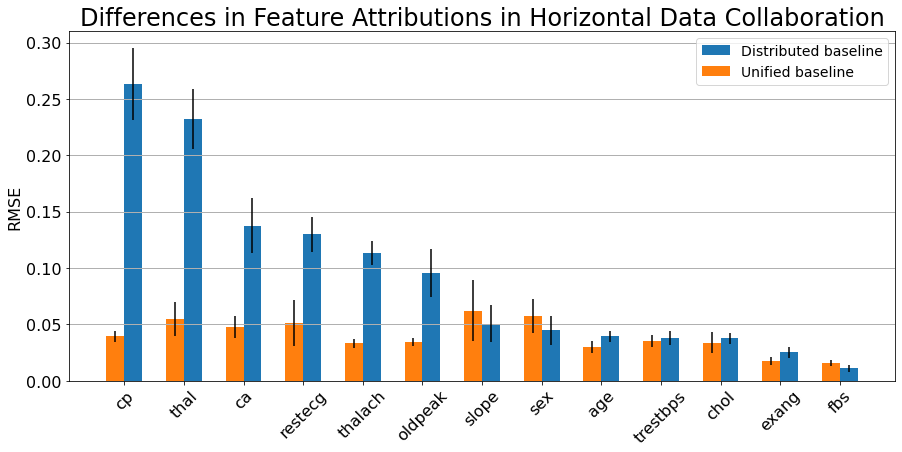

In [ ]:
import matplotlib.pyplot as plt

labels = np.array(feature_names)[ind]

scores1 = results['Distributed Baseline'][ind]
scores2 = results['Unified Baseline'][ind]

x = np.arange(len(labels))  # the label locations
width1 = 0.3  # the width of the bars
width2 = 0.3


fig, ax = plt.subplots(figsize = (13,6))

ax.bar(x + width1/2, scores1, width1, label='Distributed baseline', yerr=results['std_dist'][ind])
ax.bar(x - width2/2, scores2, width1, label='Unified baseline', yerr=results['std_anc'][ind])
#rects3 = ax.bar(x + 2*width , scores3-0.8, width, bottom=0.8, label='User3')
# rects4 = ax.bar(x + width*1.5, scores4-0.85, width, bottom=0.85, label='label_3')

# ax[1] = ax[0].twinx()
# ax[1].bar(x + width1/2, impact_dist, width2, label='Distributed baseline')
# ax[1].bar(x - width2/2, impact_anc, width2, label='Unified baseline')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE', fontsize=16)
ax.set_title('Differences in Feature Attributions in Horizontal Data Collaboration', fontsize=24)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30)
ax.legend(fontsize=14, loc='upper right')
#ax.set_yscale('log')
# ax[1].set_ylabel('Mean Absolute Feature Attribution', fontsize=16)

# ax[1].set_xticks(x)
# ax[1].set_xticklabels(labels, rotation=30)
# ax[1].legend(fontsize=14, loc='upper right')

fig.tight_layout()

plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
ax.yaxis.grid(linewidth=1)

plt.show()


# Vertical DC setup

In [ ]:
def convert_test_data(Xtest, dc):
  DC_test1 = dc.convert_embedding(Xtest[:, feat1], 0)
  DC_test2 = dc.convert_embedding(Xtest[:, feat2], 1)
  DC_test = np.hstack([DC_test1, DC_test2])
  return DC_test

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=100, random_state=0)

# #scale data
# sc = StandardScaler()
# Xtrain = sc.fit_transform(Xtrain)
# Xtest = sc.transform(Xtest)

feat1 = [0,1,2,3,4,5]
feat2 = [6,7,8,9,10,11]
X1, y1 = Xtrain[:, feat1], ytrain
X2, y2 = Xtrain[:, feat2], ytrain

# ytrain[ytrain==2] = 1
# ytest[ytest==2] = 1

clf_cntr = KNeighborsClassifier(n_neighbors=12, algorithm='kd_tree')
clf_cntr.fit(Xtrain, ytrain)
print('Centralized score: ', clf_cntr.score(Xtest, ytest))

Xtest1 = Xtest[:, feat1]
Xtest2 = Xtest[:, feat2]
clf_ind = KNeighborsClassifier(n_neighbors=12, algorithm='kd_tree')
clf_ind.fit(X1, ytrain)
print('Host individual score: ', clf_ind.score(Xtest1, ytest))

pd.DataFrame(X1, columns=np.array(feature_names)[feat1]).head()

Centralized score:  0.82
Host individual score:  0.79


,Age,Education Num,Capital Gain,Capital Loss,Hours per week,Workclass
0,45,10,0,1848,40,4
1,56,10,0,0,40,1
2,50,9,0,0,40,0
3,29,9,0,0,40,4
4,43,14,0,0,40,4


In [ ]:
Xtest.shape

(100, 12)

In [ ]:
# prepare parameters and make anchor data
p = 4
d = 4
nanc = 100

X_anc = make_anchors(Xtrain, nanc, categorical_index=[5,6,7,8,9,10,11])
X_anc1 = X_anc[:, feat1]
X_anc2 = X_anc[:, feat2]

In [ ]:
# Data Collaboration
dc = DataColab([X_anc1, X_anc2], p, d)

Y1, Yanc1 = dc.get_embedding(X1, X_anc1, p)
Y2, Yanc2 = dc.get_embedding(X2, X_anc2, p)

DC_train = np.hstack([Y1, Y2])
DC_train.shape

#clf = KNeighborsClassifier(n_neighbors=5)
#clf = RandomForestClassifier(max_depth=15, n_estimators=100, max_features=2)
#clf = DecisionTreeClassifier(max_depth=7)
#clf = MLPClassifier(alpha=1, max_iter=1000)
#clf =  SVC(gamma=2, C=1)
#clf = AdaBoostClassifier(n_estimators=100)
#clf= QuadraticDiscriminantAnalysis()
clf_dc = KNeighborsClassifier(n_neighbors=7, algorithm='kd_tree')
clf_dc.fit(DC_train, ytrain)
clf_dc.score(convert_test_data(Xtest, dc), ytest)

0.84

# Vertical DC-SHAP Experiments

----------------------------------------------------------------------------------------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>



<BarContainer object of 12 artists>

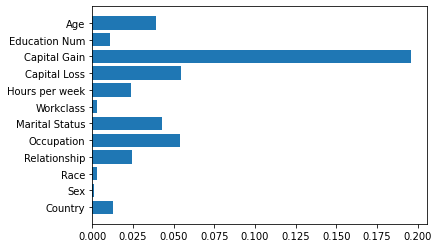

In [ ]:
# all features DC
shap.initjs()

coefs_dc = np.zeros((Xtest.shape[0], Xtest.shape[1]))
ref = np.mean(Xtest, 0).reshape(1,-1)

print("-"*Xtest.shape[0])
for i, sample in enumerate(Xtest):
  exp, coefs_dc[i] = shap_dc_vert_all(sample, ref, clf_dc, dc, feature_names, label=1)
print('\n')
coefs_dc_mean = np.mean(np.abs(coefs_dc), 0)

plt.barh(feature_names[::-1], coefs_dc_mean[::-1])

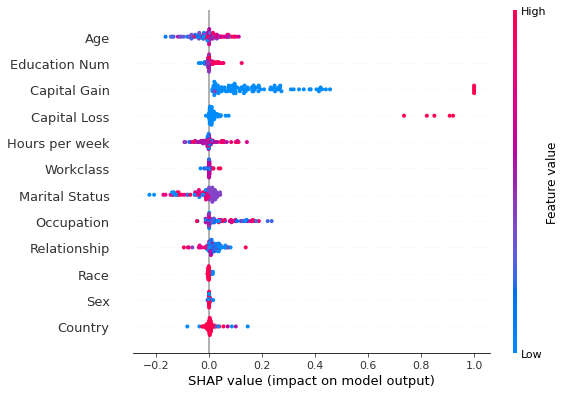

In [ ]:
samples = Xtest
shap.summary_plot(coefs_dc, pd.DataFrame(samples, columns=feature_names), sort=False)

----------------------------------------------------------------------------------------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>



<BarContainer object of 7 artists>

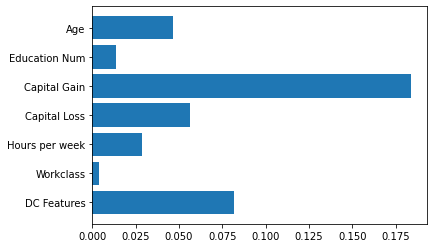

In [ ]:
# host features DC
coefs_host3 = np.zeros((samples.shape[0], Xtest1.shape[1]+1))

print("-"*samples.shape[0])

host_names = list(np.array(feature_names)[feat1])

for i, sample in enumerate(samples):
  Y_sample = dc.convert_embedding(sample[feat2], 1).reshape(1,-1)
  exp_host, coefs_host3[i] = shap_dc_vert_partial(sample[feat1].reshape(1,-1), ref, Y_sample, clf_dc, dc, list(np.array(feature_names)[feat1]), feat_pos=feat1, user=0, label=1)

print('\n')
coefs_mean_host3 = np.mean(np.abs(coefs_host3), 0)

host_names = list(np.array(feature_names)[feat1]) + ['DC Features']
plt.barh(host_names[::-1], coefs_mean_host3[::-1])

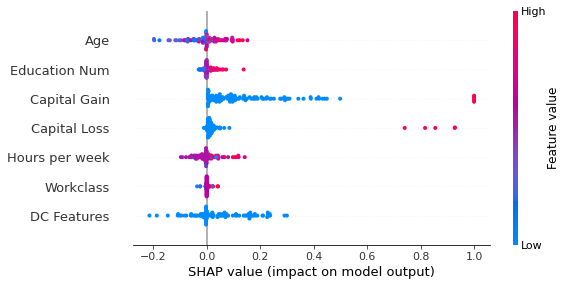

In [ ]:
# build new df
new_samples = np.hstack([samples[:, feat1], np.zeros(samples.shape[0]).reshape(-1,1)])

shap.summary_plot(coefs_host3, pd.DataFrame(new_samples, columns=host_names), sort=False)

----------------------------------------------------------------------------------------------------
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>



<BarContainer object of 7 artists>

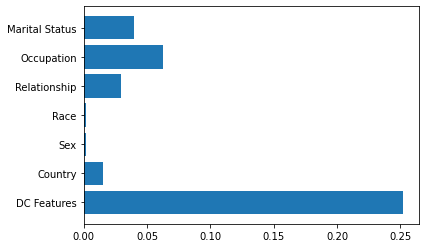

In [ ]:
# guest features DC
coefs_guest3 = np.zeros((samples.shape[0], Xtest2.shape[1]+1))

print("-"*samples.shape[0])

guest_names = list(np.array(feature_names)[feat2])

for i, sample in enumerate(samples):
  Y_sample = dc.convert_embedding(sample[feat1], 0).reshape(1,-1)
  exp_guest, coefs_guest3[i] = shap_dc_vert_partial(sample[feat2].reshape(1,-1), ref, Y_sample, clf_dc, dc, list(np.array(feature_names)[feat2]), feat_pos=feat2, user=1, label=1)

print('\n')
coefs_mean_guest3 = np.mean(np.abs(coefs_guest3), 0)

guest_names = list(np.array(feature_names)[feat2]) + ['DC Features']
plt.barh(guest_names[::-1], coefs_mean_guest3[::-1])

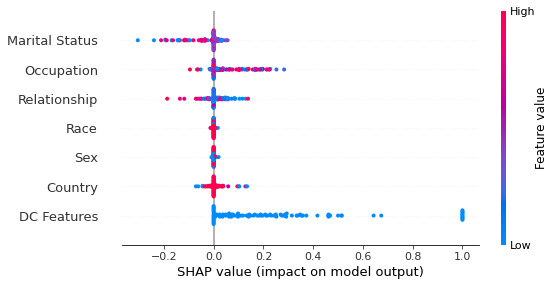

In [ ]:
# build new df
new_samples2 = np.hstack([samples[:, feat2], np.zeros(samples.shape[0]).reshape(-1,1)])
sample_df = pd.DataFrame(new_samples2, columns=guest_names)
shap.summary_plot(coefs_guest3, sample_df, sort=False)